In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
import seaborn as sns
import shap
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline

In [89]:
# Crea i dati per predire il prezzo tra 3 ggs

stock = "KO"

df = pd.read_csv(
    f"csv/{stock}_indicators.csv",
    index_col=0,       # use first column ("Date") as index
    parse_dates=[0],    # parse it as datetime
    date_format="ISO8601" #Specify date fromat
) 

df["Train"] = df["Close"].shift(-3)
df.dropna(subset=['Train'], inplace=True)


Found 28 features with positive correlation to 'Train'.


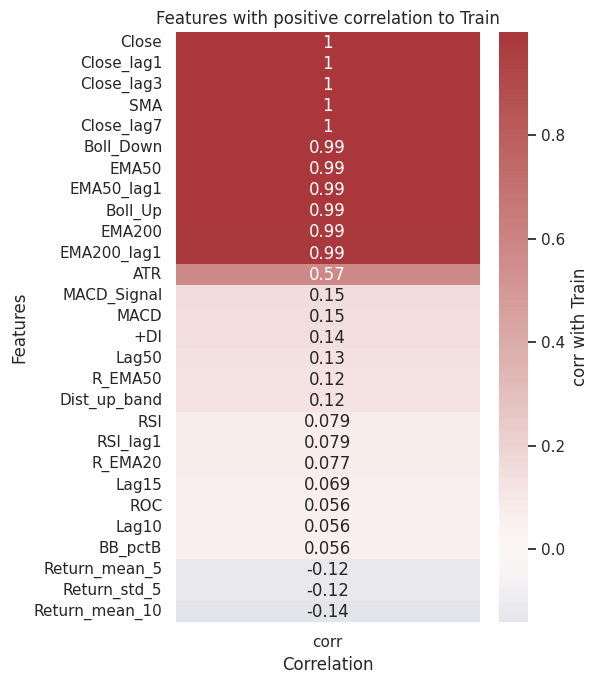

In [90]:
# List features with correlation > 0 w.r.t 'Train' and plot their correlations
if 'Train' not in df.columns:
    print("Column 'Train' not found in df. Run the data prep cell first.")
else:
    # Espressa anche close, per retrocmpatibiltà con il codice sotto stante
    corr = df.corr()
    # extract correlation with Train (drop the Train->Train self-correlation)
    corr_train = corr['Train'].drop(labels=['Train'], errors='ignore')
    significant_features = corr_train[abs(corr_train) > 0.05].sort_values(ascending=False)

    print(f"Found {len(significant_features)} features with positive correlation to 'Train'.")
    plt.figure(figsize=(6, max(4, 0.25 * len(significant_features))))
    sns.set_theme(style='white')
    # Convert to DataFrame for heatmap (required shape: (n, 1))
    pos_df = significant_features.to_frame('corr')
    ax = sns.heatmap(pos_df, annot=True, cmap='vlag', center=0, cbar_kws={'label': 'corr with Train'})
    ax.set_xlabel('Correlation')
    ax.set_ylabel('Features')
    plt.title("Features with positive correlation to Train")
    plt.tight_layout()
    plt.show()

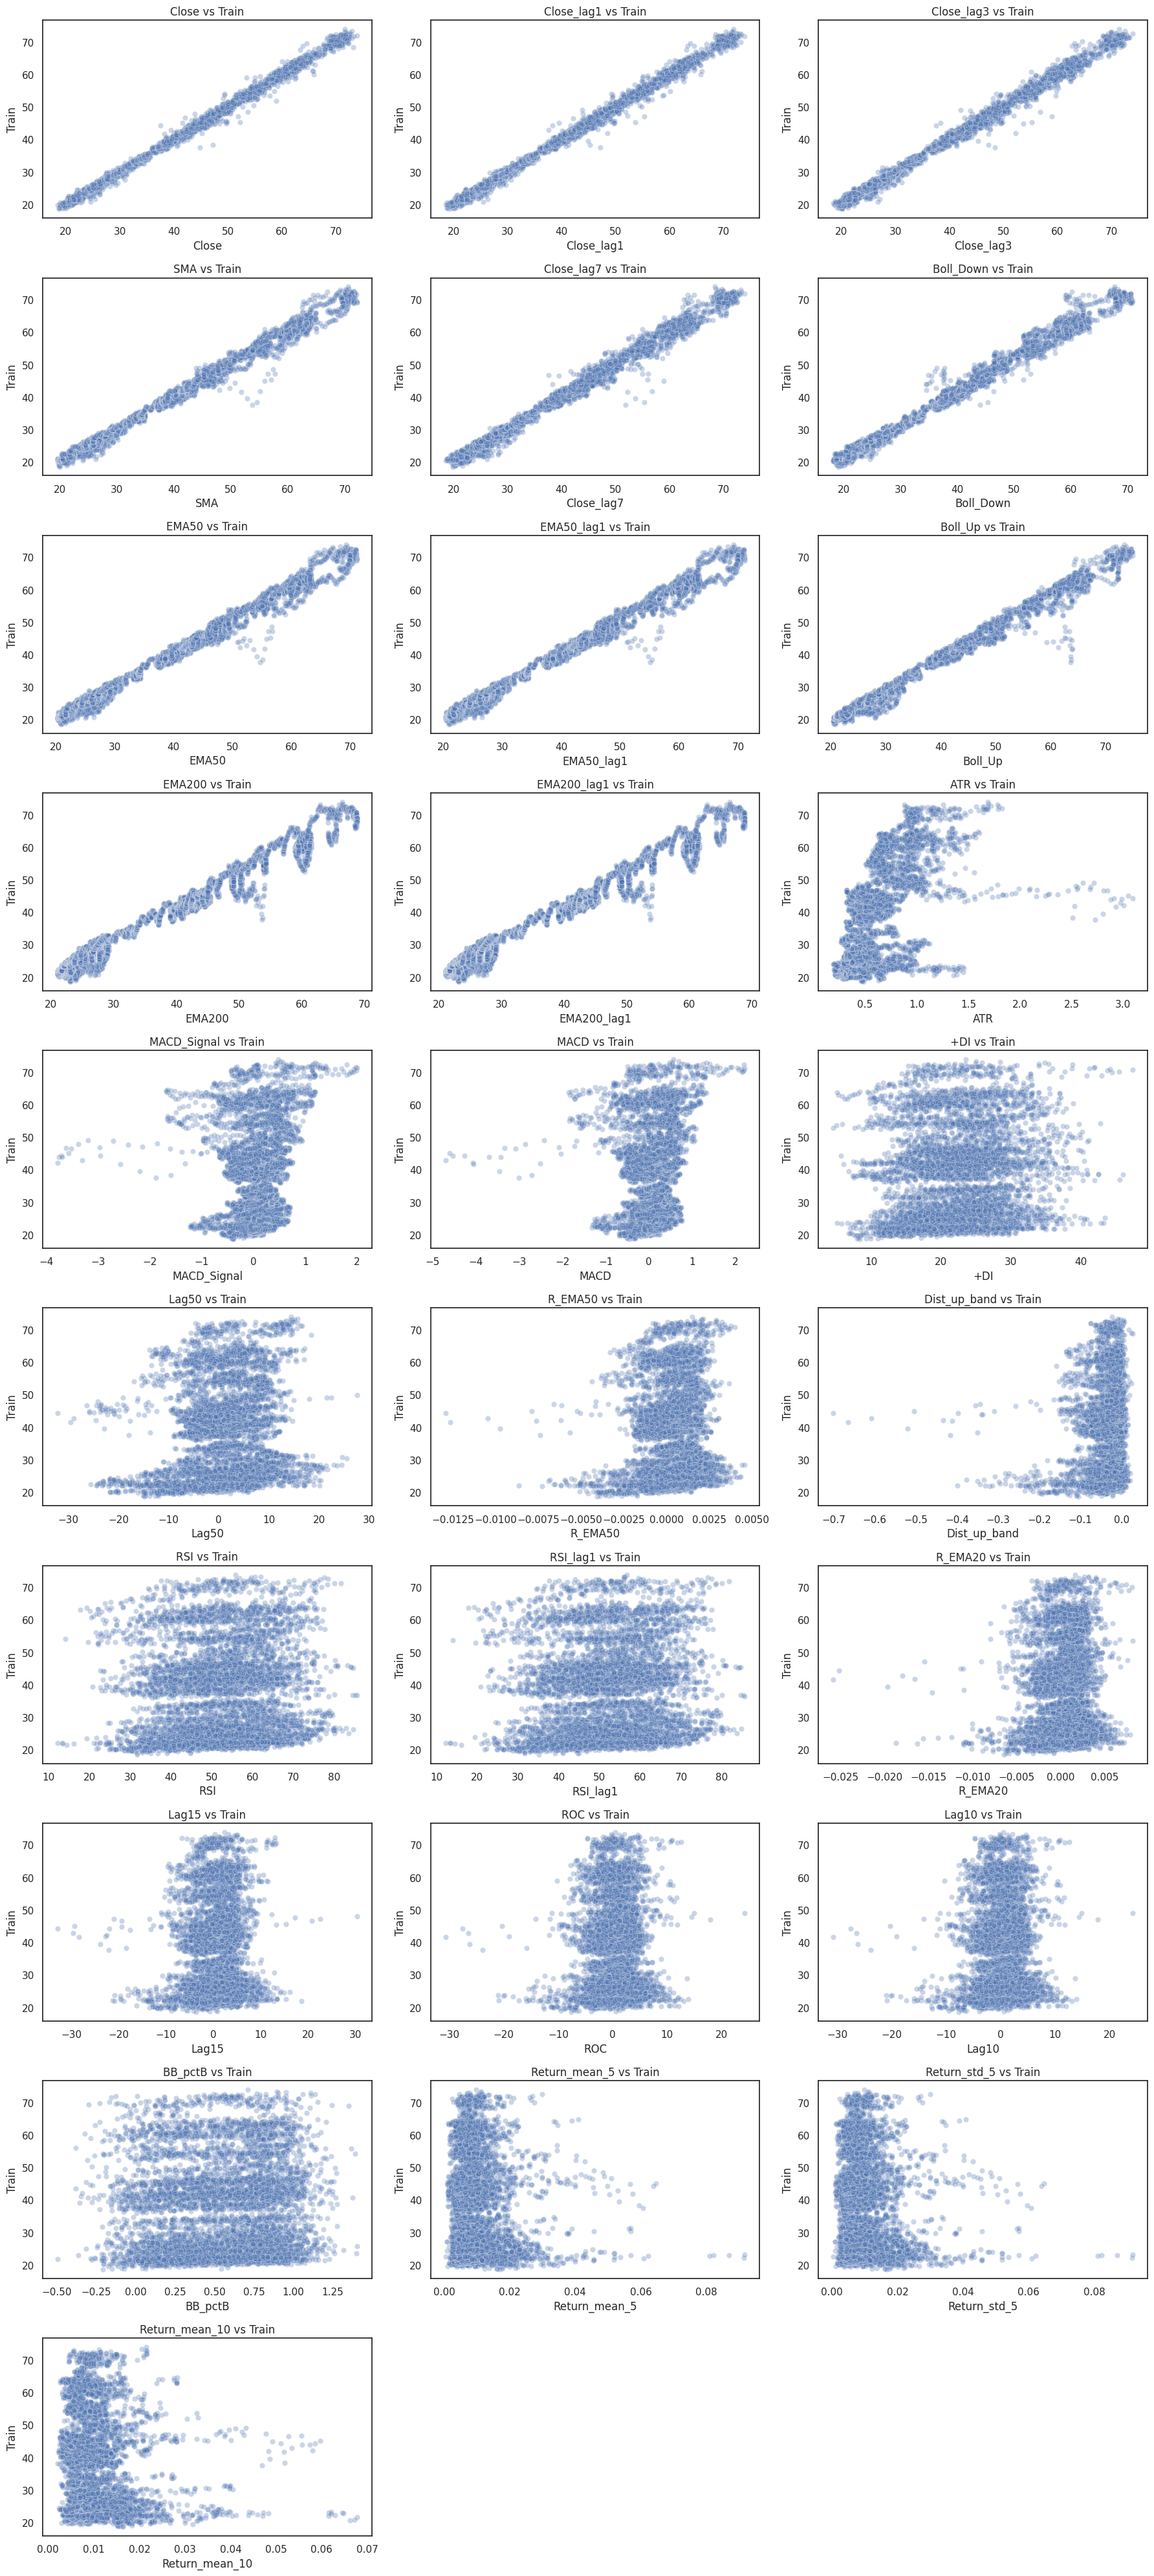

In [91]:
#Scatter plot
cols = list(df[significant_features.index].columns)
n = len(cols)
cols_per_row = 3
rows = (n + cols_per_row - 1) // cols_per_row
fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 6, rows * 4), squeeze=False)
axes_flat = axes.flatten()
for idx, col in enumerate(cols):
    ax = axes_flat[idx]
    sns.scatterplot(ax=ax, data=df, x=col, y='Train', alpha=0.3)
    ax.set_title(f"{col} vs Train")
# hide any unused subplots
for ax in axes_flat[n:]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()

In [92]:
#Data set 
featues = ["Close_lag1", "Close_lag3", "Close_lag7", "SMA", "Boll_Up", "Boll_Down", "EMA50", "EMA50_lag1", "EMA200", "EMA200_lag1", "ATR"]
X = df[featues]
Y = df["Train"]
tscv = TimeSeriesSplit(n_splits=2)

data_set = []
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    # Only keep the Close values that correspond to the test indices
    data_set.append({
        "X_train": X_train.copy(),
        "X_test": X_test.copy(),
        "Y_train": Y_train.copy(),
        "Y_test": Y_test.copy(),
        "Reality": df.loc[X_test.index, "Close"].copy()
    })

Stock: KO
Best params: {'lasso__alpha': 0.01, 'lasso__max_iter': 10000}
RMSE: 0.7675 | MAE: 0.6171 | R2: 0.9856 | base R2: 0.9916
                   coef  mean_abs_shap
Close_lag1      2.58488        32.9401
Boll_Down       0.18779        2.39265
SMA             0.13689        1.73846
EMA200_lag1 -0.00773573      0.0893797
Close_lag3            0              0
Close_lag7            0              0
Boll_Up               0              0
EMA50                 0              0
EMA50_lag1            0              0
EMA200               -0              0
ATR                  -0              0


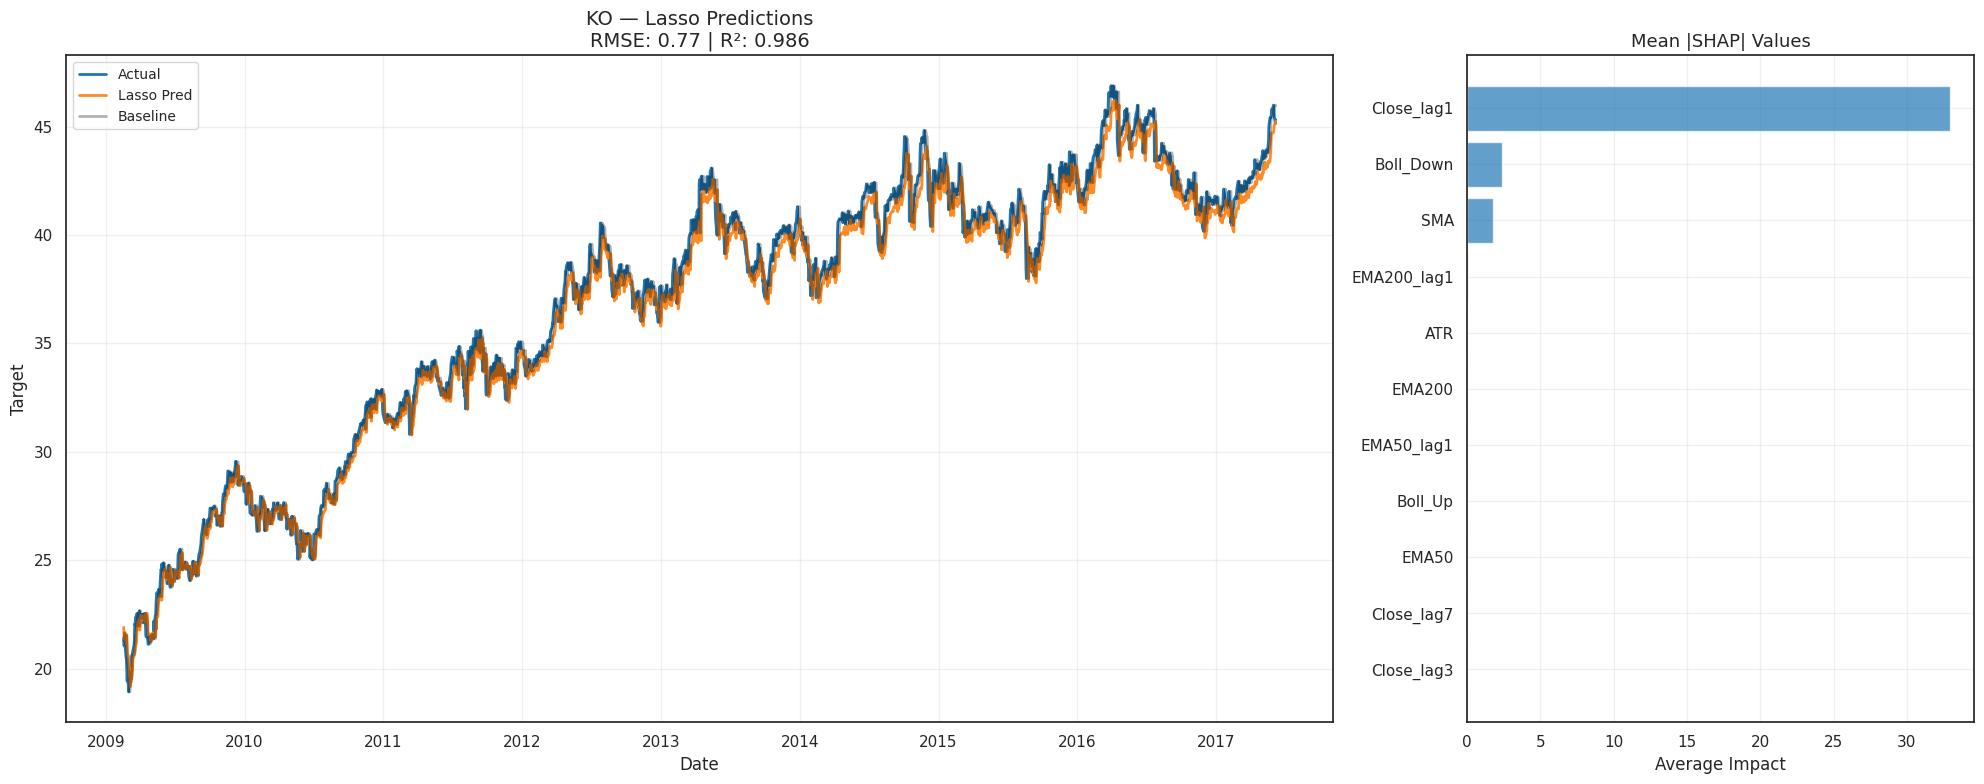

Stock: KO
Best params: {'lasso__alpha': 0.01, 'lasso__max_iter': 10000}
RMSE: 1.2753 | MAE: 0.9020 | R2: 0.9756 | base R2: 0.9816
                  coef  mean_abs_shap
Close_lag1     7.13461        175.221
SMA           0.654765        16.0211
EMA200        0.109224         2.5959
Boll_Up       0.100876        2.55538
ATR         -0.0420041      0.0155468
Close_lag7           0              0
Close_lag3           0              0
EMA50                0              0
Boll_Down            0              0
EMA50_lag1           0              0
EMA200_lag1          0              0


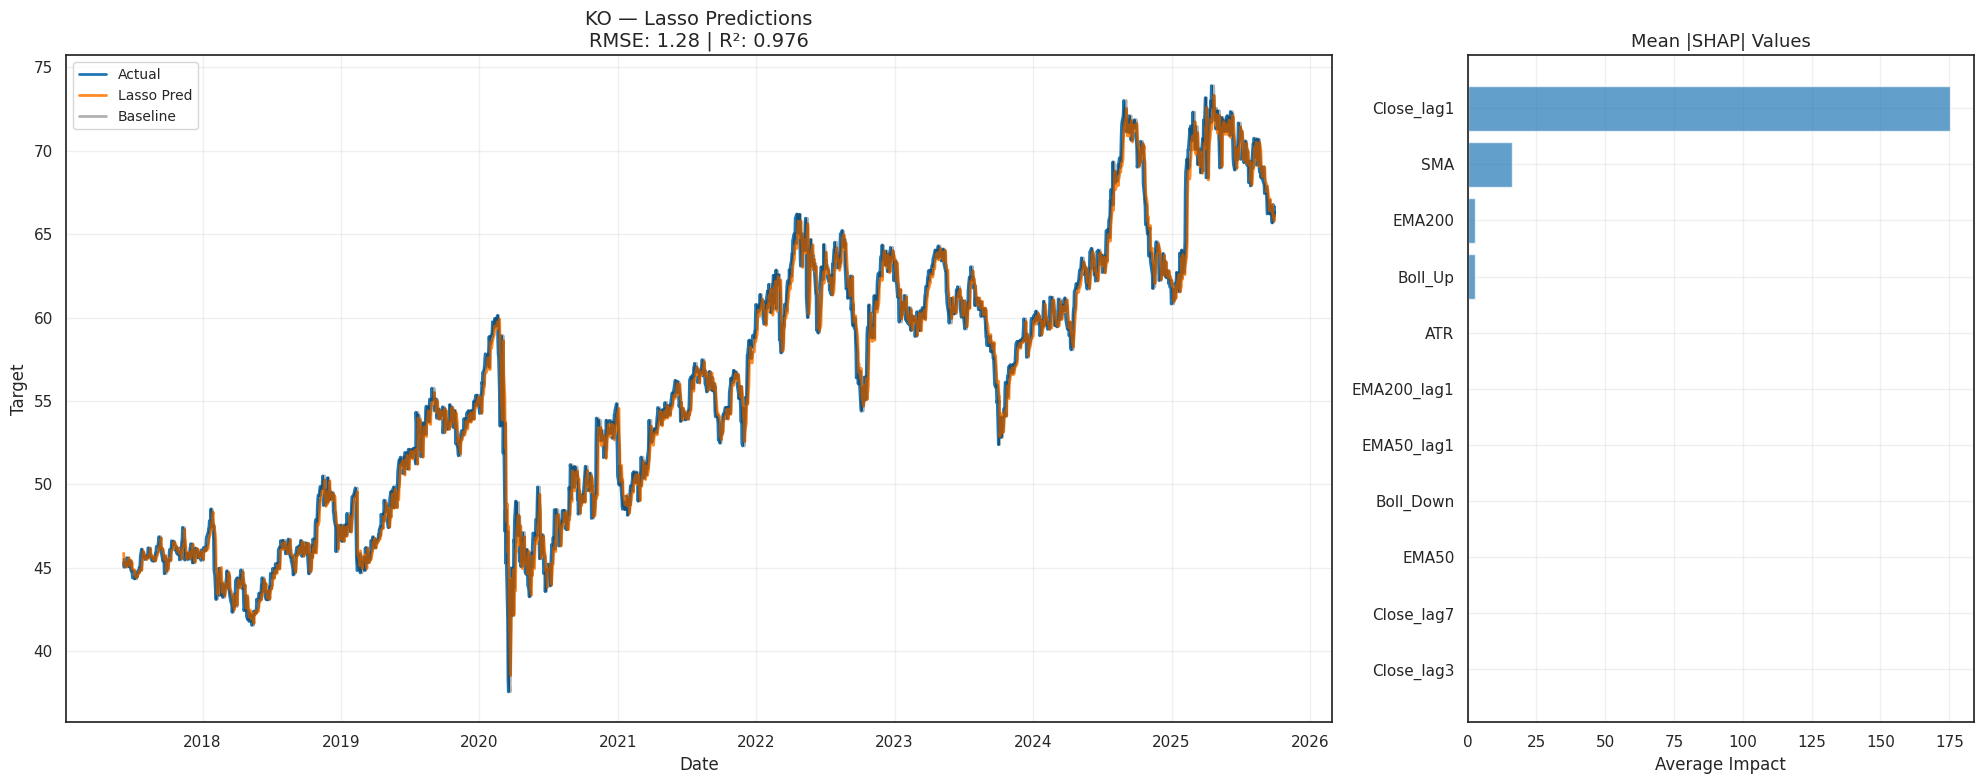

In [93]:
#Lasso regression
for data in data_set:
    pipe = make_pipeline(StandardScaler(), Lasso(random_state=42, max_iter=20000))

    param_grid = {
        'lasso__alpha': [0.01, 0.1, 0.5, 0.5, 1.0], 
        'lasso__max_iter': [10000, 50000, 100000]
    }
    gs = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=0)
    gs.fit(data["X_train"], data["Y_train"])

    best = gs.best_estimator_
    y_pred = best.predict(data["X_test"])

    mse = mean_squared_error(data["Y_test"], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["Y_test"], y_pred)
    r2 = r2_score(data["Y_test"], y_pred)
    base = r2_score(data["Y_test"], data["Reality"])

    print(f"Stock: {stock}")
    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f} | base R2: {base:.4f}")

    # coefficients
    lasso = best.named_steps['lasso']
    coefs = pd.Series(lasso.coef_, index=data["X_train"].columns)

    # compute SHAP values (try recommended masker, fallback to Explainer)
    shap_values = None
    try:
        masker = shap.maskers.Independent(data["X_train"])  # type: ignore
        explainer = shap.LinearExplainer(lasso, masker=masker)
        shap_values = explainer(data["X_test"])
    except Exception:
        try:
            explainer = shap.Explainer(lasso, data["X_train"])
            shap_values = explainer(data["X_test"])
        except Exception:
            shap_values = None

    # prepare combined table (coef + mean |SHAP|)
    if shap_values is None:
        combined = pd.DataFrame({"coef": coefs})
        combined["abs_coef"] = combined["coef"].abs()
        combined = combined.sort_values("abs_coef", ascending=False)
        print("SHAP unavailable — coefficients ordered by |coef|:")
        print(combined[["coef"]].to_string(float_format=lambda x: f"{x:.6g}"))
    else:
        if hasattr(shap_values, "values"):
            sv = shap_values.values
        else:
            sv = shap_values
        if isinstance(sv, list):
            sv = sv[0]
        mean_abs = np.mean(np.abs(sv), axis=0)
        shap_series = pd.Series(mean_abs, index=data["X_test"].columns)

        combined = pd.DataFrame({
            "coef": coefs,
            "abs_coef": coefs.abs(),
            "mean_abs_shap": shap_series
        }).fillna(0)

        combined = combined.sort_values("abs_coef", ascending=False)
        print(combined[["coef", "mean_abs_shap"]].to_string(float_format=lambda x: f"{x:.6g}"))

    # --- ONE figure with two panels ---
    fig, (ax_main, ax_shap) = plt.subplots(
        1, 2,
        figsize=(20, 8),                   # this WILL now control the size
        gridspec_kw={'width_ratios': [2.5, 1]}
    )

    # ---- MAIN PLOT ----
    ax_main.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    ax_main.plot(data["Y_test"].index, y_pred, label='Lasso Pred', color='#ff7f0e', linewidth=2, alpha=0.9)
    ax_main.plot(data["Y_test"].index, data["Reality"], label='Baseline', color='#000000', linewidth=2, alpha=0.3)

    ax_main.set_title(f"{stock} — Lasso Predictions\nRMSE: {rmse:.2f} | R²: {r2:.3f}", fontsize=14)
    ax_main.set_xlabel("Date", fontsize=12)
    ax_main.set_ylabel("Target", fontsize=12)
    ax_main.legend(fontsize=10)
    ax_main.grid(alpha=0.3)

    # ---- SHAP PLOT (manual bar chart) ----
    try:
        if hasattr(shap_values, "values"):
            sv = shap_values.values # type: ignore
        else:
            sv = shap_values
        if isinstance(sv, list):
            sv = sv[0]

        # Compute mean absolute SHAP values
        mean_abs = np.mean(np.abs(sv), axis=0)
        shap_series = pd.Series(mean_abs, index=data["X_test"].columns)
        shap_series = shap_series.sort_values(ascending=True)

        # Horizontal bar chart
        ax_shap.barh(shap_series.index, shap_series.values, color="#1f77b4", alpha=0.7)
        ax_shap.set_title("Mean |SHAP| Values", fontsize=13)
        ax_shap.set_xlabel("Average Impact", fontsize=12)
        ax_shap.grid(alpha=0.3)
    except Exception as e:
        ax_shap.text(0.5, 0.5, f"SHAP plot failed:\n{e}", ha='center', va='center', fontsize=10)
        ax_shap.set_axis_off()

    plt.tight_layout()
    plt.show()

In [94]:
# LightGMB required mre tsting
"""
for data in data_set:
    pipe = Pipeline([('lgbm', LGBMRegressor(force_row_wise=True, random_state=42))])

    param_grid = {
        'lgbm__n_estimators': [300, 1000],
        'lgbm__learning_rate': [0.01, 0.1],
        'lgbm__num_leaves': [31, 50]
    }
    gs = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=0)
    gs.fit(data["X_train"], data["Y_train"])

    best = gs.best_estimator_
    y_pred = best.predict(data["X_test"])

    mse = mean_squared_error(data["Y_test"], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["Y_test"], y_pred)
    r2 = r2_score(data["Y_test"], y_pred)
    base = r2_score(data["Y_test"], data["Reality"])

    print(f"Stock: {stock}")
    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f} | base R2: {base:.4f}")

    # feature importances as 'coef' equivalent
    model = best.named_steps['lgbm']
    try:
        coefs = pd.Series(model.feature_importances_, index=data["X_train"].columns)
    except Exception:
        coefs = pd.Series(0, index=data["X_train"].columns)

    # compute SHAP values (TreeExplainer preferred)
    shap_values = None
    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(data["X_test"])
    except Exception:
        try:
            explainer = shap.Explainer(model, data["X_train"])
            shap_values = explainer(data["X_test"])
        except Exception:
            shap_values = None

    # prepare combined table (importance + mean |SHAP|)
    if shap_values is None:
        combined = pd.DataFrame({"coef": coefs})
        combined["abs_coef"] = combined["coef"].abs()
        combined = combined.sort_values("abs_coef", ascending=False)
        print("SHAP unavailable — features ordered by importance:")
        print(combined[["coef"]].to_string(float_format=lambda x: f"{x:.6g}"))
    else:
        # shap_values may be list (multi-output) or array
        if isinstance(shap_values, list):
            # regression usually returns array; if list with one element use that
            if len(shap_values) == 1:
                sv = shap_values[0]
            else:
                sv = np.array(shap_values).mean(axis=0)
        elif hasattr(shap_values, "values"):
            sv = shap_values.values # type: ignore
        else:
            sv = shap_values

        mean_abs = np.mean(np.abs(sv), axis=0)
        shap_series = pd.Series(mean_abs, index=data["X_test"].columns)

        combined = pd.DataFrame({
            "coef": coefs,
            "abs_coef": coefs.abs(),
            "mean_abs_shap": shap_series
        }).fillna(0)

        combined = combined.sort_values("abs_coef", ascending=False)
        print("Top features (ordered by importance) with corresponding mean |SHAP|:")
        print(combined[["coef", "mean_abs_shap"]].to_string(float_format=lambda x: f"{x:.6g}"))

    # single figure: left = actual vs predicted, right = SHAP summary (bar)
    fig, (ax_main, ax_shap) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 1]})

    # main time-series plot on left
    ax_main.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    ax_main.plot(data["Y_test"].index, y_pred, label='LightGBM Pred', color='#ff7f0e', linewidth=2, alpha=0.9)
    ax_main.plot(data["Y_test"].index, data["Reality"], label='baseline', color='#000000', linewidth=2, alpha=0.9)
    ax_main.set_title(f"{stock} — LightGBM predictions (RMSE: {rmse:.2f}, R2: {r2:.3f})")
    ax_main.set_xlabel("Date")
    ax_main.set_ylabel("Target")
    ax_main.legend()
    ax_main.grid(alpha=0.3)

    # SHAP bar summary on right
    try:
        # build a horizontal bar chart from combined (ordered by abs coef)
        plot_series = combined["mean_abs_shap"].sort_values(ascending=True)
        ax_shap.barh(plot_series.index, plot_series.values, color="#1f77b4", alpha=0.8)
        ax_shap.set_title("Mean |SHAP|")
        ax_shap.set_xlabel("Average Impact")
        ax_shap.grid(alpha=0.3)
    except Exception as e:
        ax_shap.text(0.5, 0.5, f"SHAP plot failed:\n{e}", ha='center', va='center')
        ax_shap.set_axis_off()

    plt.tight_layout()
    plt.show()
"""

'\nfor data in data_set:\n    pipe = Pipeline([(\'lgbm\', LGBMRegressor(force_row_wise=True, random_state=42))])\n\n    param_grid = {\n        \'lgbm__n_estimators\': [300, 1000],\n        \'lgbm__learning_rate\': [0.01, 0.1],\n        \'lgbm__num_leaves\': [31, 50]\n    }\n    gs = GridSearchCV(pipe, param_grid, scoring=\'neg_mean_squared_error\', cv=3, n_jobs=-1, verbose=0)\n    gs.fit(data["X_train"], data["Y_train"])\n\n    best = gs.best_estimator_\n    y_pred = best.predict(data["X_test"])\n\n    mse = mean_squared_error(data["Y_test"], y_pred)\n    rmse = np.sqrt(mse)\n    mae = mean_absolute_error(data["Y_test"], y_pred)\n    r2 = r2_score(data["Y_test"], y_pred)\n    base = r2_score(data["Y_test"], data["Reality"])\n\n    print(f"Stock: {stock}")\n    print(f"Best params: {gs.best_params_}")\n    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f} | base R2: {base:.4f}")\n\n    # feature importances as \'coef\' equivalent\n    model = best.named_steps[\'lgbm\']\n    try:

Stock: KO
Best params: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.9}
RMSE: 0.7732 | MAE: 0.6227 | R2: 0.9854 | base R2: 0.9916
                  coef  mean_abs_shap
Close_lag1     2.53678        32.3271
Boll_Down     0.198069        2.52361
SMA           0.180677        2.29454
EMA200_lag1 -0.0154995       0.179083
Close_lag3           0              0
Close_lag7           0              0
Boll_Up              0              0
EMA50                0              0
EMA50_lag1           0              0
EMA200              -0              0
ATR                 -0              0


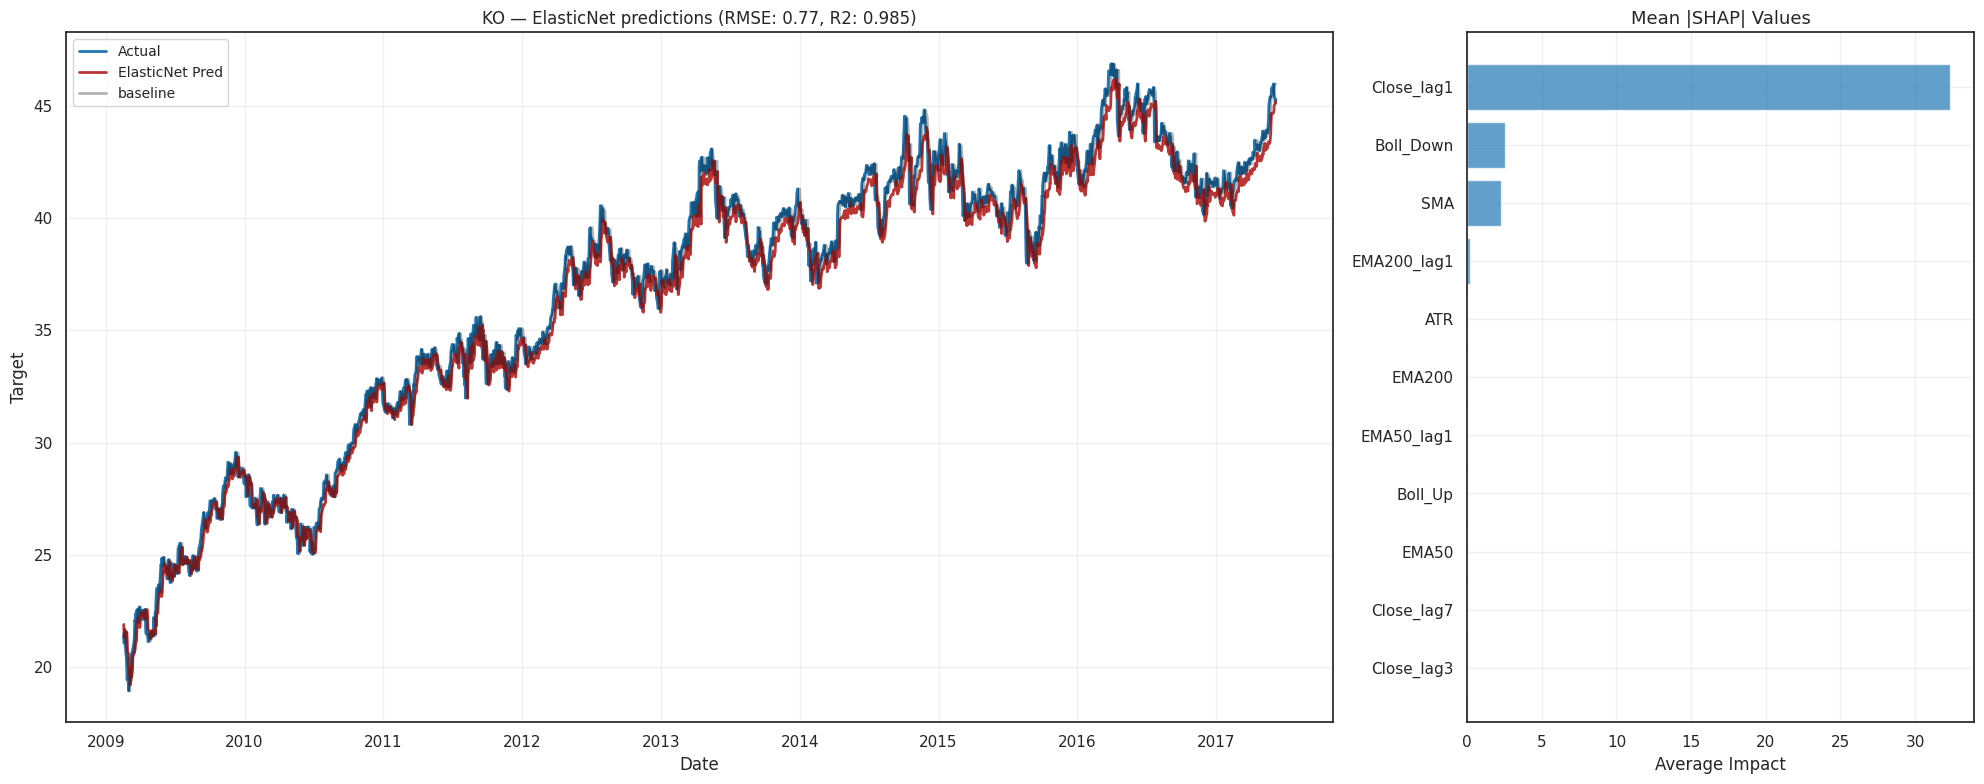

Stock: KO
Best params: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.9}
RMSE: 1.2939 | MAE: 0.9188 | R2: 0.9749 | base R2: 0.9816
                  coef  mean_abs_shap
Close_lag1     5.81492         142.81
Close_lag3    0.935291        22.9655
SMA           0.840595        20.5681
Boll_Up       0.217406        5.50731
EMA200        0.100513        2.38887
Boll_Down    0.0922366        2.17725
ATR         -0.0544612      0.0201574
Close_lag7           0              0
EMA50                0              0
EMA50_lag1           0              0
EMA200_lag1          0              0


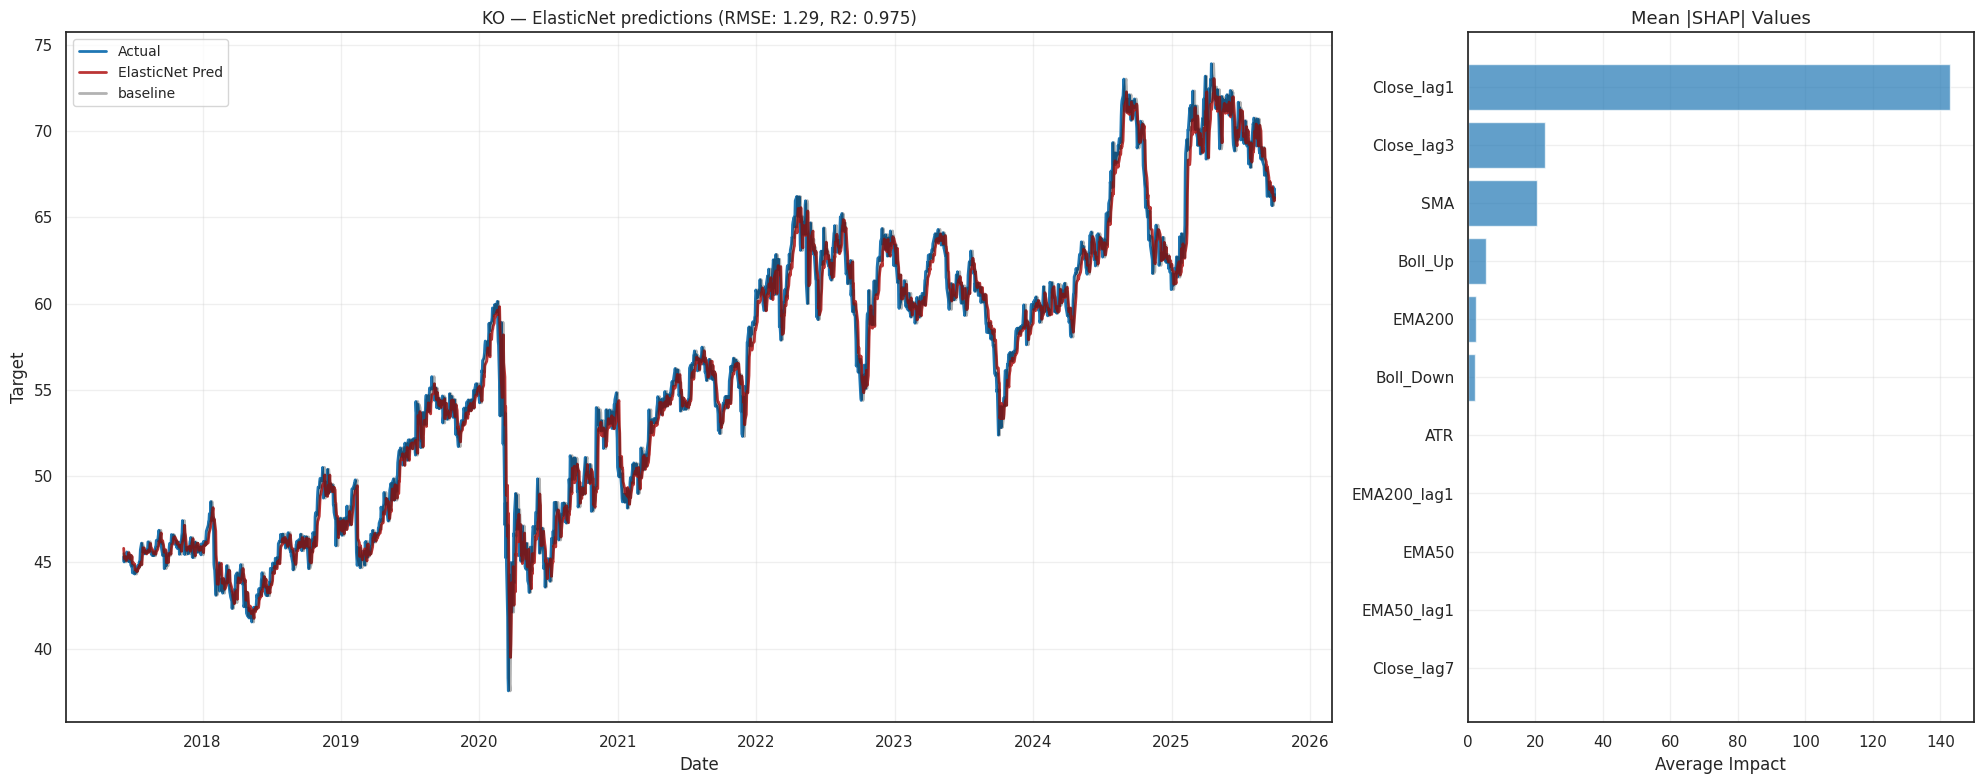

In [95]:
# Elatic-net
for data in data_set:
    pipe = make_pipeline(StandardScaler(), ElasticNet(random_state=42, max_iter=20000))

    param_grid = {
        'elasticnet__alpha': [0.01, 0.1, 0.5, 1.0],
        'elasticnet__l1_ratio': [0.1, 0.5, 0.9]
    }
    gs = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=0)
    gs.fit(data["X_train"], data["Y_train"])

    best = gs.best_estimator_
    y_pred = best.predict(data["X_test"])

    mse = mean_squared_error(data["Y_test"], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["Y_test"], y_pred)
    r2 = r2_score(data["Y_test"], y_pred)
    base = r2_score(data["Y_test"], data["Reality"])

    print(f"Stock: {stock}")
    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f} | base R2: {base:.4f}")

    # display top coefficients
    try:
        enet = best.named_steps['elasticnet']
        coefs = pd.Series(enet.coef_, index=data["X_train"].columns)
    except Exception:
        pass

    # compute SHAP values (try recommended masker, fallback to Explainer)
    shap_values = None
    try:
        masker = shap.maskers.Independent(data["X_train"])  # type: ignore
        explainer = shap.LinearExplainer(enet, masker=masker)
        shap_values = explainer(data["X_test"])
    except Exception:
        try:
            explainer = shap.Explainer(enet, data["X_train"])
            shap_values = explainer(data["X_test"])
        except Exception:
            shap_values = None

    # prepare combined table (coef + mean |SHAP|)
    if shap_values is None:
        combined = pd.DataFrame({"coef": coefs})
        combined["abs_coef"] = combined["coef"].abs()
        combined = combined.sort_values("abs_coef", ascending=False)
        print("SHAP unavailable — coefficients ordered by |coef|:")
        print(combined[["coef"]].to_string(float_format=lambda x: f"{x:.6g}"))
    else:
        if hasattr(shap_values, "values"):
            sv = shap_values.values
        else:
            sv = shap_values
        if isinstance(sv, list):
            sv = sv[0]
        mean_abs = np.mean(np.abs(sv), axis=0)
        shap_series = pd.Series(mean_abs, index=data["X_test"].columns)

        combined = pd.DataFrame({
            "coef": coefs,
            "abs_coef": coefs.abs(),
            "mean_abs_shap": shap_series
        }).fillna(0)

        combined = combined.sort_values("abs_coef", ascending=False)
        print(combined[["coef", "mean_abs_shap"]].to_string(float_format=lambda x: f"{x:.6g}"))

    # --- ONE figure with two panels ---
    fig, (ax_main, ax_shap) = plt.subplots(
        1, 2,
        figsize=(20, 8),                   # this WILL now control the size
        gridspec_kw={'width_ratios': [2.5, 1]}
    )

    # ---- MAIN PLOT ----
    ax_main.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    ax_main.plot(data["Y_test"].index, y_pred, label='ElasticNet Pred', color='#b41f1f', linewidth=2, alpha=0.9)
    ax_main.plot(data["Y_test"].index, data["Reality"], label='baseline', color='#000000', linewidth=2, alpha=0.3)

    ax_main.set_title(f"{stock} — ElasticNet predictions (RMSE: {rmse:.2f}, R2: {r2:.3f})")
    ax_main.set_xlabel("Date", fontsize=12)
    ax_main.set_ylabel("Target", fontsize=12)
    ax_main.legend(fontsize=10)
    ax_main.grid(alpha=0.3)

    # ---- SHAP PLOT (manual bar chart) ----
    try:
        if hasattr(shap_values, "values"):
            sv = shap_values.values # type: ignore
        else:
            sv = shap_values
        if isinstance(sv, list):
            sv = sv[0]

        # Compute mean absolute SHAP values
        mean_abs = np.mean(np.abs(sv), axis=0)
        shap_series = pd.Series(mean_abs, index=data["X_test"].columns)
        shap_series = shap_series.sort_values(ascending=True)

        # Horizontal bar chart
        ax_shap.barh(shap_series.index, shap_series.values, color="#1f77b4", alpha=0.7)
        ax_shap.set_title("Mean |SHAP| Values", fontsize=13)
        ax_shap.set_xlabel("Average Impact", fontsize=12)
        ax_shap.grid(alpha=0.3)
    except Exception as e:
        ax_shap.text(0.5, 0.5, f"SHAP plot failed:\n{e}", ha='center', va='center', fontsize=10)
        ax_shap.set_axis_off()

    plt.tight_layout()
    plt.show()